In [ ]:
import scipy.stats as stats
from myst_nb import glue
import scipy.stats as stats
%config InlineBackend.figure_formats = ['svg']

(psth-section)=
# The peri-stimulus time histogram


The peri-stimulus (or peri-event) time histogram (PSTH/PETH) is one of the most prevalent analyses in systems neuroscience. Its original usage was in identifying responses of single neurons to specific events in time (where the events were action potentials), but it can also be used to analyze time series of specific behaviors, estimate connected cell pairs, and analyze any number of other ways in which streams of events might relate to other events in time.

Here, we're going to work through the process of creating a simple PSTH using Python, noting along the way how various parameter choices capture relevant statistical assumptions and tradeoffs as well as affecting the look and feel of the resulting plots.

We'll start with some sample data, shown in the raster plot below:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#set random seed
np.random.seed(12345)

In [ ]:
# time axis: 
dt = 0.001
taxis = np.arange(-0.5, 1.5, dt)
rate = dt * np.ones_like(taxis)

# in [0, 1] rate is 10Hz
up_rate = 10 * dt
rate[(0 < taxis) & (taxis < 1)] = up_rate

# generate counts
ntrials = 50
counts = stats.poisson.rvs(rate, size=(ntrials, len(rate)))

# convert to event times
trials, time_inds = counts.nonzero()
times = taxis[time_inds]

In [ ]:
# raster plot
plt.scatter(times, trials, s=10, color='k')
plt.ylabel('trial')
plt.xlabel('time (s)');

It should be obvious from this representation of the data that the firing rate goes up around 0 and down around 1 second later. In fact, these are artificial data generated from the methods of the last section by assuming that the firing rate is 1 Hz at baseline, increases to 10 Hz at 0.0, and falls again to baseline at 1.0 s. This highly contrived example &mdash; real data rarely look this clean &mdash; will allow us to examine the tradeoffs endemic in constructing the PSTH in a case where we know the ground truth.

## Binning

In the following sections, we'll assume we have our data in the form of two vectors, `times`, which contains the times of all the spikes, and `trials`, a vector of the same length that indicates the trial to which each spike belongs. 

```{admonition} Question
It is more typical that data would be given as a list of lists, with each sub-list containing the spike times for that trial. How would you convert those data into the form we assume here?

What if the times were given relative to a wall clock time (not trial onset), but you were given the start time of each trial?
```

Given these data, we want to construct a histogram, in which the heights of histogram bars indicate _counts_. But in order to turn spike times into counts, we need to decide what time intervals will define our discrete bins. There are two ways to get these counts: 
1. We can use [`np.histogram`](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) to get them, specifying either the number of bins (as an integer) or the bin edges (as a vector).
1. We can use [`plt.hist`](https://matplotlib.org/stable/gallery/statistics/hist.html#histograms) to make a bar plot of the result (which calls `np.histogram` under the hood).

Here, we'll use the slightly more cumbersome method of specifying bin edges, since in neural data analysis we are typically more interested in specifying bin size than the number of bins.

In [ ]:
#specify a set of bin sizes (in s)
bin_sizes = [0.005, 0.01, 0.02, 0.05] 

# make a 2 x 2 grid of plots
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, tight_layout=True)

# loop over bin sizes
# make a PSTH for each one
# zip pairs up the lists of bin sizes and axes
for b, ax in zip(bin_sizes, axes.flatten()):
    # make bins spaced b apart
    bin_edges = np.arange(-0.5, 1.5, b)
    ax.hist(times, bins=bin_edges)
    ax.set_title(f"Bin size = {b * 1000:.0f} ms")
    ax.set_ylabel("Count")


A few things should stick out to you about the effects bin size has on the PSTH:
- The small the bins, the fewer events in each bin. As a result, smaller bins lead to less (visually) apparent increases in firing.
- Smaller bins result in "spikier" estimates of firing rate during the 1 s period of elevated firing. This is true despite the fact that we know that the firing rate during this period is _constant_. Conversely, larger bin sizes lead to _relatively_ less variance in bin counts. (The absolute variance is higher, since the Poisson distribution has a variance that scales as its mean.)
- If we were concerned with estimating the onset and offset times of the elevated firing rate, larger bins would make this harder to estimate, since we would only be able to localize this event to within a time comparable to the bin size. That is, as we'll more clearly below, larger bins act as _smoothers_ of firing rate estimates.

In effect, each of these phenomena are a result of the same concept, known in statistics as the **bias-variance tradeoff**: attempts to reduce the variance of an estimate (e.g., by using a larger bin size), often come at the cost of less accurate estimates (e.g., less precise onset times). Here, we know that firing rates in the middle 1 s period are constant, but if they were changing, smaller bins would allow us to better track those small changes. But the (relative) variance of those estimates would be much higher than if we used larger bins.

## Firing rates and smoothing

What we have constructed above is the classic PSTH: a histogram of spike counts across all trials. It is what you will see in many older physiology papers. It does, however, have a couple of shortcomings:
- The quantity plotted on the y axis is spike counts, which depends on the number of trials we observe; it's not really a biological quantity of interest.
- The estimates of firing rate are specific to each bin, but if we believe firing rates vary smoothly, we might want to lower the variance in these estimates by "sharing" some statistical power across bins.

In response to these concerns, we will introduce two additional steps our analysis that are common features of more "modern" PSTHs:
- Instead of summing across trials to get counts, we will _average_ them to get estimates of _firing rate_ as in [](psth_estimator).
- We will then _smooth_ these firing rate estimates in time to trade temporal precision for a reduction in the variance of our estimates.

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, tight_layout=True,
                figsize=(10, 3))

spk_times = np.array([0.1, 0.11, .120, .122])
xmin = 0
xmax = .15
t_axis = np.arange(xmin, xmax, dt)
ymin = 0
ymax = 1.1
spk_bin = np.histogram(spk_times, bins=t_axis)[0]

plt.ylim(ymin, ymax)
plt.yticks([])
axes[0].set_xlim(-11, 11)
axes[1].set_xlim(0.09, 0.14)
axes[0].set_xlabel('time (ms)')
filter_len = 100
mini_t_axis = np.arange(-filter_len/2 + 0.5, filter_len/2 + 0.5, 1)
spk_filter = np.zeros(filter_len)
spk_filter[filter_len//2 - 1] = 1
axes[0].stem(0, 1, markerfmt='none')
axes[1].stem(spk_times + dt, np.ones_like(spk_times), markerfmt='none')

# hacky: advance the color cycle
axes[0].plot([], [])
axes[1].plot([], [])

plt.xticks([])
wid = 20  # width in ms
pad = 40
boxcar_filter = np.pad(np.ones(wid)/wid, (pad, pad))
axes[0].plot(mini_t_axis, boxcar_filter, label='boxcar')
axes[1].plot(t_axis[1:], np.convolve(spk_bin, boxcar_filter, 'same'))

gaussian_filter = stats.norm.pdf(np.arange(-.05, .05, dt), scale=.005)
gaussian_filter /= np.sum(gaussian_filter)
axes[0].plot(mini_t_axis - 0.5, gaussian_filter, label='Gaussian')
axes[1].plot(t_axis[1:], np.convolve(spk_bin, gaussian_filter, 'same'))

exponential_filter = stats.expon.pdf(np.arange(0, 0.05, dt), scale=0.002)
exponential_filter /= np.sum(exponential_filter)
exponential_filter = np.flip(exponential_filter)
exponential_filter = np.pad(exponential_filter, (0, len(exponential_filter)))
axes[0].plot(mini_t_axis + 0.5, exponential_filter, label='exponential')
axes[1].plot(t_axis[1:], np.convolve(spk_bin, exponential_filter, 'same'))

axes[0].legend();

glue("filter_illustration", fig, display=False);


```{glue:figure} filter_illustration
:name: "filter-illustration"

Effects of filter shape and width on spike rate estimation. **(Left)** A single spike (blue) and the same spike as smoothed (convolved) with a boxcar (orange), Gaussian (green), and causal exponential (red) filter. **(Right)** An example spike train smoothed using the same filters. Note that a trial-averaged PSTH is comparable to a boxcar filter with width equal to the bin width, and that the boxcar and Gaussian filters spread the influence of a spike into the both the past and the future.
```

{numref}`filter-illustration` illustrates this smoothing strategy on a simple example data set of four spikes. In each case, we have replaced a single spike with the filter itself (equivalent to a [convolution](https://en.wikipedia.org/wiki/Convolution) operation). This operation spreads the influence of the single spike in time, increasing firing rate estimates nearby while lowering them at the time of the spike itself. Note also that, except for the case of the exponential filter, this smoothing spreads firing rate estimates into the future, which means that estimated firing rates will increase _before_ the first spikes actually arrive. Thus, for cases in which latencies and onsets are important, causal filters (which only spread into the past) should always be used.

## Estimating trial-averaged firing

So let's return to our example data set and try using what we've learned to estimate firing as a function of time in trial. As with the PSTH, our first step will be to bin the data, but this time, since we'll want access to the counts, not just the plot, we'll use the `np.histogram` function. Since we're eventually going to smooth with filters of various widths, we can start by using a very fine bin size of 1 ms.

In [192]:
bin_size = 0.001 

edges = np.arange(-0.5, 1.5, bin_size)

# histogram returns a tuple (counts, edges), so take 
# only the first of these
counts = np.histogram(times, bins=edges)[0]

The next step is to smooth the counts using a filter. For this example, we'll use a Gaussian filter, though the principles remain the same for other shapes. Our strategy will be to first define a filter that has a Gaussian shape (using the Gaussian probability density function in `scipy.stats`) and then to normalize that filter so that its sum is 1.

In [223]:
import scipy.stats as stats

# standard deviation of smoothing filter
smooth_widths = [0.02, 0.050, 0.100, 0.2]

filters = []
# now for each bin size
for s in smooth_widths:
    # make a time axis for the filter (3 std before and after)
    t_axis = np.arange(-3 * s, 3 * s, bin_size)

    # make Gaussian filter 
    gaussian_filter = stats.norm.pdf(t_axis, scale=s)

    # normalize its sum to 1
    gaussian_filter /= np.sum(gaussian_filter)

    filters.append(gaussian_filter)

Now, just as we did with our four-spike data set, we're going to use convolution to smooth the data. You can read more [here](https://en.wikipedia.org/wiki/Convolution#Visual_explanation), but the basic idea is that convolution moves the filter along the data, creating a summary of the nearby data at each stop. That is, it replaces the data value at a particular point with a weighted sum of data in the local neighborhood. In our case, we can create a plot that illustrates the effects of smoothing width on our firing rate estimate:

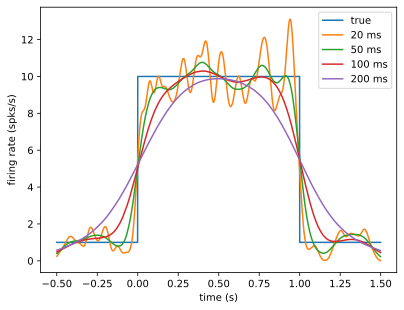

In [226]:
# include the ground truth rate for plotting
true_rate = np.ones_like(edges)
# in [0, 1] rate is 10Hz
true_rate[(0 < edges) & (edges < 1)] = 10

ntrials = 50

# plot ground truth rate
plt.plot(edges, true_rate, label='true')

# enumerate gives us both indices and values in a tuple
for idx, s in enumerate(smooth_widths):
    # since the smoothed data is an estimate of spikes per bin,
    # we need to divide by bin size and number of trials 
    # to get an estimate of rate
    rate_estimate = (counts/bin_size)/ntrials

    # convolve to get filtered data
    # 'same' returns data of the same length
    smoothed_data = np.convolve(rate_estimate, filters[idx], 'same')

    # since there are one fewer bins than edges, we use edges[1:]
    plt.plot(edges[1:], smoothed_data, label=f"{s / bin_size:.0f} ms")

plt.xlabel('time (s)')
plt.ylabel('firing rate (spks/s)')
plt.legend();

Note that the smaller-width filters are more variable but still centered around the true data, so our estimates pick up on smaller fluctuations in local spike counts while being less reliable at each point. By contrast, the larger smoothing widths are less variable but are badly biased around firing rate changes. In effect, when smoothing with a filter of width $T$, it is hard to detect changes in firing rate on scales $< T$.

```{admonition} Question
In our above analysis, we binned spikes on a very fine time scale and used smoothing to get firing rate estimates. What would happen if we had used bigger bin sizes to start? Would this have affected our final rate estimates?
```

## Beyond spikes

Though the analyses we've done here are very simple, they apply to many different types of data. For example, many experiments generate time stamps of short behaviors that can be viewed as realizations of a point process, and we are often interested in the (average) rate of such a process around sets of other events. In such cases, the PSTH is often the method of choice. Along different lines, for continuously recorded data, we may also be interested in the average time trace of the data across repetitions of the same experimental condition, again aligned to select moments in time (e.g., trial start, movement or stimulus onset, reward delivery). In this case, the PSTH is also a useful analysis (without the hassle of binning). Implicitly, the PSTH assumes that the data have a characteristic time course of interest, and this pattern repeats around some class of events whose locations we know in time. Aligning the data to these events and then averaging thus produces an estimate of this "typical" time course.